In [101]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt

from general_graph_utils import *

The goal of this notebook is to illustrate the uses of the general_graphs library. 

Using this library, one will be able to:

1. create a random linear framework graph and represent it visually

2. assign edge labels to the graph at random

3. calculate the Laplacian matrix of the graph, as well as any other relevant quantities (e.g. steady state distribution, spectrum of the matrix, FPTs)

# Create a random linear framework graph

In [125]:
def random_graph(n):
    """
    Randomly generates a linear framework graph -- a finite, directed graph with no self-loops -- that is strongly connected and fully reversible. The size of the graph is randomly determined from range (3, n), and the edges are added by randomly selecting a pair of nodes in G.
    
    Parameters
    ----------
    n : integer
        the maximum number of vertices
    
    Returns
    -------
    G : NetworkX DiGraph object
        directed graph
    
    G_ud : NetworkX Graph object
        undirected graph
    """
    
    G = nx.DiGraph()
    G_ud = nx.Graph()
    
    # determine the number of nodes in G
    G_size = np.random.choice(np.arange(3,n), size=1)
    
    # add nodes to G and G_ud
    nodes = np.arange(1,G_size+1,step=1)
    G.add_nodes_from(nodes)
    G_ud.add_nodes_from(nodes)
    
    # add edges until the graph is strongly connected
    while nx.is_strongly_connected(G) == False:
        u, v = np.random.choice(nodes, size=2,replace=False)
        G.add_edge(u,v)
        G_ud.add_edge(u,v)
    
    # add edges such that the graph is fully reversible
    for edge in G.edges:
        u = edge[0]
        v = edge[1]
        if G.has_edge(v,u) == False:
            G.add_edge(v,u)
            G_ud.add_edge(v,u)
    
    return G, G_ud

In [126]:
n = 10
G, G_ud = random_graph(n)

# Assign edge labels at random

In [127]:
def get_labels(G):
    """
    Extracts the label information for each edge in a NetworkX graph object. If G not labeled, labels are logarithmically sampled.
    
    Note: works for undirected graph, but if given a choice, better to use a directed graph
    
    Parameters
    ----------
    G : NetworkX graph object (directed)
            
    Returns
    -------
    label_dict : dictionary
        keys: edges in G represented as tuple (source,sink), values: edge labels
        
    label_list : 1D numpy array
        list of edge labels in G
        
    """
    
    label_dict = {}
    
    if nx.is_weighted(G)==True:
        for i in range(len(G.edges())):
            label_dict[list(G.edges())[i]] = G.get_edge_data(list(G.edges)[i][0],list(G.edges)[i][1])['weight']
        
    elif nx.is_weighted(G)==False:        

        for e in G.edges():
            label = np.around(10**(np.random.uniform(-3,3, size = 1)[0]),decimals=3)
            label_dict[e] = label
            u = e[0]
            v = e[1]
            G[u][v]['weight'] = label
        
    label_list = np.fromiter(label_dict.values(), dtype=float)
    
    return label_dict, label_list

In [128]:
node_list = get_nodes(G)
edge_list = get_edges(G)
label_dict, label_list = get_labels(G)
cycle_list = get_cycle_nodes(G_ud)
num_cycles = len(cycle_list)

In [129]:
label_dict

{(1, 4): 0.029,
 (1, 2): 0.005,
 (1, 3): 0.544,
 (2, 5): 0.001,
 (2, 3): 0.023,
 (2, 1): 6.168,
 (2, 4): 0.97,
 (3, 4): 78.757,
 (3, 1): 14.249,
 (3, 2): 0.427,
 (3, 5): 0.29,
 (4, 3): 2.123,
 (4, 1): 105.298,
 (4, 5): 22.383,
 (4, 2): 0.03,
 (5, 2): 0.043,
 (5, 3): 0.033,
 (5, 4): 0.208}

In [130]:
nx.get_edge_attributes(G, 'weight')

{(1, 4): 0.029,
 (1, 2): 0.005,
 (1, 3): 0.544,
 (2, 5): 0.001,
 (2, 3): 0.023,
 (2, 1): 6.168,
 (2, 4): 0.97,
 (3, 4): 78.757,
 (3, 1): 14.249,
 (3, 2): 0.427,
 (3, 5): 0.29,
 (4, 3): 2.123,
 (4, 1): 105.298,
 (4, 5): 22.383,
 (4, 2): 0.03,
 (5, 2): 0.043,
 (5, 3): 0.033,
 (5, 4): 0.208}

In [131]:
edge_weights = nx.get_edge_attributes(G,'weight')
edge_weights

{(1, 4): 0.029,
 (1, 2): 0.005,
 (1, 3): 0.544,
 (2, 5): 0.001,
 (2, 3): 0.023,
 (2, 1): 6.168,
 (2, 4): 0.97,
 (3, 4): 78.757,
 (3, 1): 14.249,
 (3, 2): 0.427,
 (3, 5): 0.29,
 (4, 3): 2.123,
 (4, 1): 105.298,
 (4, 5): 22.383,
 (4, 2): 0.03,
 (5, 2): 0.043,
 (5, 3): 0.033,
 (5, 4): 0.208}

# Draw the resulting graph

In [132]:
# This function was taken from: https://stackoverflow.com/questions/22785849/drawing-multiple-edges-between-two-nodes-with-networkx, answer by kcoskun.

def my_draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=None,
    label_pos=0.25,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):
    """Draw edge labels.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    edge_labels : dictionary (default={})
        Edge labels in a dictionary of labels keyed by edge two-tuple.
        Only labels for the keys in the dictionary are drawn.

    label_pos : float (default=0.5)
        Position of edge label along edge (0=head, 0.5=center, 1=tail)

    font_size : int (default=10)
        Font size for text labels

    font_color : string (default='k' black)
        Font color string

    font_weight : string (default='normal')
        Font weight

    font_family : string (default='sans-serif')
        Font family

    alpha : float or None (default=None)
        The text transparency

    bbox : Matplotlib bbox, optional
        Specify text box properties (e.g. shape, color etc.) for edge labels.
        Default is {boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)}.

    horizontalalignment : string (default='center')
        Horizontal alignment {'center', 'right', 'left'}

    verticalalignment : string (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    rotate : bool (deafult=True)
        Rotate edge labels to lie parallel to edges

    clip_on : bool (default=True)
        Turn on clipping of edge labels at axis boundaries

    Returns
    -------
    dict
        `dict` of labels keyed by edge

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_nodes
    draw_networkx_edges
    draw_networkx_labels
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items


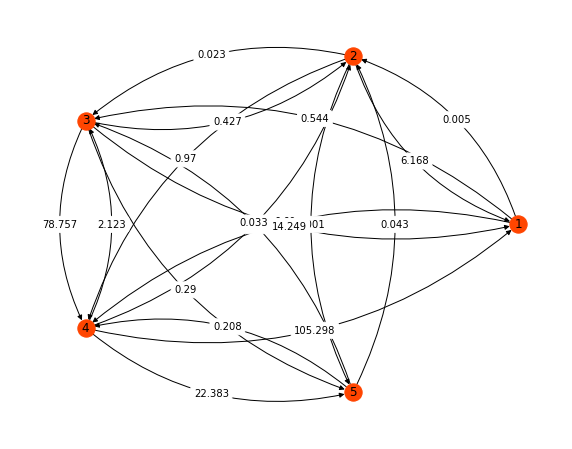

In [138]:
plt.rc("figure",figsize=(10,8))

fig, ax = plt.subplots()

pos = nx.circular_layout(G)

nx.draw_networkx_nodes(G, pos, ax = ax, node_color = 'orangered')
nx.draw_networkx_labels(G, pos, ax=ax)

curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
straight_edges = list(set(G.edges()) - set(curved_edges))
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges, arrows=True)
arc_rad = 0.25
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}', arrows=True)

edge_weights = nx.get_edge_attributes(G,'weight')
curved_edge_labels = {edge: np.around(edge_weights[edge], decimals=3) for edge in curved_edges}
straight_edge_labels = {edge: np.around(edge_weights[edge], decimals=3) for edge in straight_edges}
my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad)
nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=straight_edge_labels,rotate=False)

ax.set_facecolor('white')
ax.axis('off')
fig.set_facecolor('white')
plt.show()

# Calculate the Laplacian matrix of the graph and compute other quantities

In [139]:
def Laplacian_all(edge_list,label_list,node_list):
    """
    Calculates the Laplacian matrix for any graph. The entries of the Laplacian are computed using the following mathematical formula:
    
    L_{ij}(G) = e_{ij} if i \neq j
    L_{ij}(G) = -\sum_{v \neq j} e_{vj} if i = j.
    
    Parameters
    ----------
    edge_list : 1D array
        list of each edge in the graph object G, each element is a tuple (source,sink)
    
    label_list : 1D array
        list of edge labels in the graph
        
    node_list : 1D array
        list of nodes in the graph
    
    Returns
    -------
    
    L : num_nodes x num_nodes array
        the Laplacian matrix of the graph G
        
    """
    
    num_nodes = len(node_list)
    num_edges = len(edge_list)
    
    L = np.zeros(shape=(num_nodes,num_nodes),dtype=np.float128)
    
    # off-diagonal entries
    for x in range(num_edges):
        k = np.around(edge_list[x][0]-1,decimals=5)
        j = np.around(edge_list[x][1]-1,decimals=5)

        L[k,j] = label_list[x]
    
    # diagonal entries
    sums = np.around(-1*np.sum(L,axis=0), decimals=5)

    for i in range(num_nodes):
        L[i,i] = sums[i]
    
    return L